# **Natural Language Processing (NLP)**

In [30]:
!nvidia-smi

Mon Jan 17 13:27:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |  11848MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dataset and dataloader

In this laboratory exercise, we will work with [IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/) and our goal will be to create a model that will be able to determine if the certain movie review is positive or negative.

In [32]:
# torchtext package consists of data processing utilities and popular datasets for natural language
import torchtext

Implement the dataset

In [33]:
from torchtext.datasets import IMDB

imdb_train_iter, imdb_test_iter = IMDB(split=('train', 'test'))

In [34]:
next(imdb_train_iter)
# label (positive/negative), text

('neg',
 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [35]:
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

LABELS = ["pos", "neg"]
MAX_LEN = 60

class MovieReviewsDataset(Dataset):
    def __init__(self, data_iter, tokenizer=get_tokenizer("basic_english"), vocab=None, vocab_min_freq=10):
      self.instances = [instance for instance in data_iter]

      self.tokenizer = tokenizer

      # Create vocabulary
      tokens = [tokenizer(text) for _, text in self.instances]

      for k in range(len(tokens)):
        tokens[k] = tokens[k][-MAX_LEN:]

      self.text_vocab = None
      if vocab is not None:
        self.text_vocab = vocab
      else:
        self.text_vocab = build_vocab_from_iterator(tokens, min_freq=vocab_min_freq, specials=["<pad>", "<unk>"])
        self.text_vocab.set_default_index(self.text_vocab["<unk>"])

      self.label_vocab = build_vocab_from_iterator([tokenizer(l) for l in LABELS])

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
      # return (TEXT, LABEL) (encoded with vocabulary)
      return torch.LongTensor(self.text_vocab(self.tokenizer(self.instances[idx][1]))), self.label_vocab(self.tokenizer(self.instances[idx][0]))[0]


In [36]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [37]:
imdb_train = MovieReviewsDataset(imdb_train_iter)
imdb_test = MovieReviewsDataset(imdb_test_iter, vocab=imdb_train.text_vocab)

In [38]:
imdb_train.text_vocab["bad"]

75

In [39]:
imdb_train[0]

(tensor([  12,  248, 1876, 4365,   11,    6,    1,    5, 1505,    1, 1615,    2,
           10,  177,    7,   25,  535,   62,   33,    7,   16, 1033, 2423,   32,
          103,   13,   21,   50,  983,   29,  691,  538,   28,  100,  587,    2,
           24,   19,    3, 3206,   15, 5417, 1136,  791,   11,   45,    1, 6467,
            4,   15,  233,    7,   25,  257,    2,   12,    7,  139,  111,    1,
          113,   26, 1136,  791,    2, 2588,    4,   40,   69, 1300,   58, 6803,
         2423,    4,   20,  164,   32,    3,    1,  113,   26,    1,    1,    5,
            1,    1,   51, 1338,    4,  103,   40,   70,    7,   25, 2023,    2,
            3,  178,  388,   19,  146, 1442, 1405,  287,    1,    1,   14,    3,
            1,   20,   27,    6,    1,   14, 1810,    2,    5,  146, 1505, 1960,
           91,   38,    3, 2319, 5071,    4,   14,   83,   96,    7,  151, 2464,
            9,    3, 2278,    8, 4355,    1,    7,   16,    1, 3318,    4,   20,
           27,    6, 7070,  

In [40]:
imdb_train.instances[0]

('neg',
 '"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, 

Define collate function. Collate function is a function that merges a list of samples to form a mini-batch of Tensor. We need it because not all samples have the same length.

In [41]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch, pad_index=0):
    lengths = torch.Tensor([len(b[0]) for b in batch])
    
    txts = [b[0] for b in batch]
    labels = torch.tensor([b[1] for b in batch]).float() 
    
    return pad_sequence(txts, batch_first=True, padding_value=pad_index), labels, lengths

Create dataloaders (we'll use previously implemented 'collate_batch' function)

In [42]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(imdb_train, batch_size=64, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(imdb_test, batch_size=64, collate_fn=collate_batch)

In [43]:
for txts, labels, lengths in train_dataloader:
  print(lengths)
  print(lengths.shape)
  break

tensor([ 342.,  257.,  153.,  241.,  245.,  126.,   76.,  220.,  691.,  509.,
         481.,  206.,  150.,   50.,  277.,  174.,   89.,  235.,  285.,  130.,
        1153.,  119.,  146.,  357.,  148.,  167.,  193.,  211.,  155.,  370.,
         387.,  280.,  135.,  211.,  115.,  152.,  209.,  161.,  307.,  276.,
         154.,  357.,  237.,   99.,  163.,  156.,  412.,  159.,  149.,  365.,
         691.,  945.,  157.,  241.,  361.,  189.,   67.,  244.,  371.,  133.,
         548.,  148.,  197.,  136.])
torch.Size([64])


# RNN

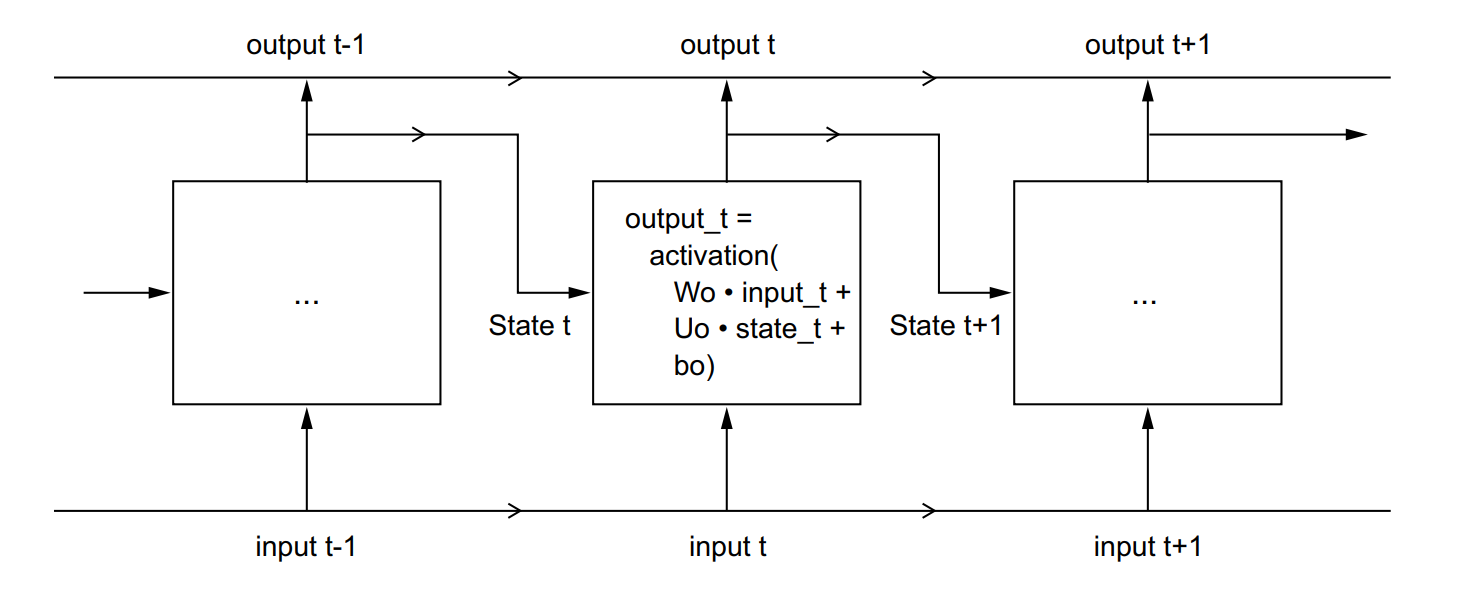

In [44]:
class RNNModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, num_layers=2):
    super(RNNModel, self).__init__()

    self.encoder = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
    
    self.linear1 = nn.Linear(2 * hidden_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    embedded = self.encoder(x)
    rnn_out, hidden = self.rnn(embedded)

    hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

    output = hidden
    output = self.linear1(output)
    output = self.linear2(output)

    return output.squeeze(-1)


# Attention

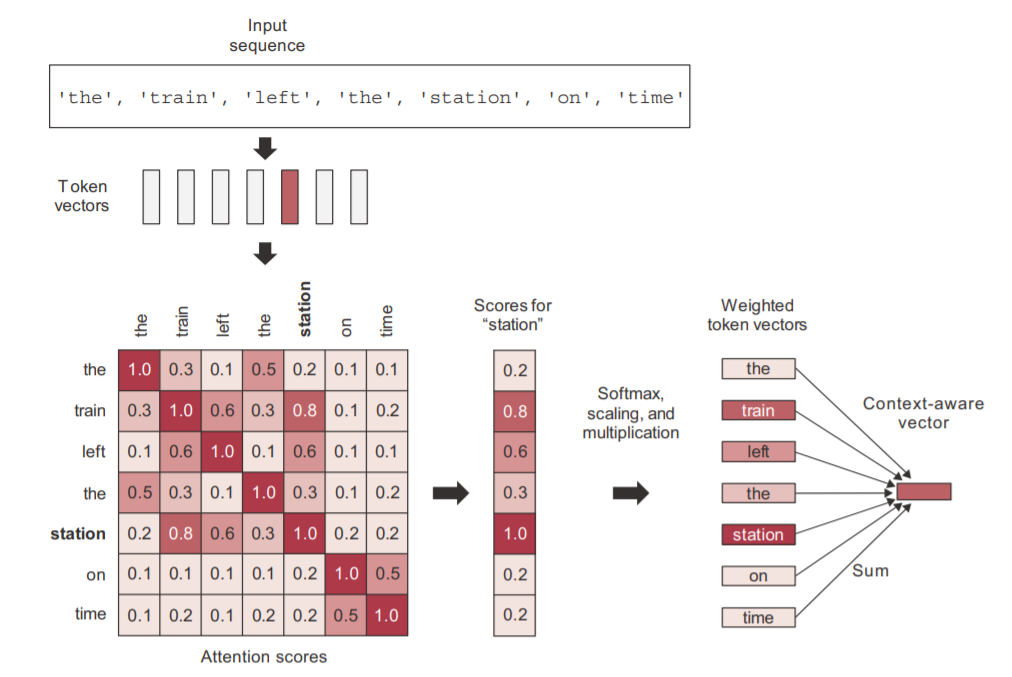

In [46]:
class AttentionModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim=128, num_heads=4):
    super(AttentionModel, self).__init__()

    self.encoder = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    self.attn = nn.MultiheadAttention(embedding_dim, num_heads, batch_first=True)
    
    self.linear1 = nn.Linear(embedding_dim, embedding_dim // 2)
    self.linear2 = nn.Linear(embedding_dim//2, 1)

  def forward(self, x):
    embedded = self.encoder(x)

    attn_out, _ = self.attn(query=embedded, key=embedded, value=embedded)

    output = attn_out.mean(dim=1)
    output = self.linear1(output)
    output = self.linear2(output)

    return output.squeeze(-1)

# Training

In [47]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [48]:
def evaluate(model, eval_dataloader, desc_text="Testing"):
  model.eval()
  with torch.no_grad():
    eval_loss = []
    correct = 0
    count = 0

    for eval_batch in tqdm(eval_dataloader, desc=desc_text):
      x, y, _ = eval_batch
      x = x.cuda(0)
      y = y.cuda(0)
      logits = model(x)
      loss = F.binary_cross_entropy_with_logits(logits, y)
      eval_loss.append(loss)

      correct += ((torch.sigmoid(logits) >= 0.5).float() == y).float().sum()
      count += len(y)

  eval_loss = torch.mean(torch.tensor(eval_loss))
  eval_acc = correct / count
    
  model.train()

  return eval_loss, eval_acc

In [49]:
def train(model, train_dataloader, test_dataloader, num_epochs=5, lr=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.cuda(0)

  # TRAINING
  model.train()

  for epoch in range(num_epochs):
    with tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f'Training (epoch={epoch}/{num_epochs})') as epoch_progress:
      for batch_idx, train_batch in epoch_progress:
        x, y, _ = train_batch
        x = x.cuda(0)
        y = y.cuda(0)
        logits = model(x)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        acc = ((torch.sigmoid(logits) >= 0.5).float() == y).float().sum() / len(y)
        epoch_progress.set_postfix({'loss': loss.item(), 'acc': acc.item()})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # TEST
  test_loss, test_acc = evaluate(model, test_dataloader, desc_text="Testing")

  print()
  print(f"--- TEST ---")
  print("loss: ", test_loss.item())
  print("accuracy: ", test_acc.item())

In [50]:
train_dataloader = DataLoader(imdb_train, batch_size=64, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(imdb_test, batch_size=64, collate_fn=collate_batch)

train(RNNModel(len(imdb_train.text_vocab)), train_dataloader, test_dataloader)

Testing: 100%|██████████| 391/391 [00:28<00:00, 13.85it/s]


--- TEST ---
loss:  0.6809863448143005
accuracy:  0.5807999968528748


In [51]:
train_dataloader = DataLoader(imdb_train, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(imdb_test, batch_size=16, collate_fn=collate_batch)

train(AttentionModel(len(imdb_train.text_vocab)), train_dataloader, test_dataloader)

Testing: 100%|██████████| 1563/1563 [00:10<00:00, 146.55it/s]


--- TEST ---
loss:  0.3703683912754059
accuracy:  0.8802799582481384
